In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import preprocessing

In [2]:
%run utils/base.py
%run utils/loading.py
%run utils/attention_graph.py
%run utils/mlflow_query.py

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"))
mlflow_helper.query_valid_runs(pkl_file=Path("mlflow_run_df.pkl"))

Initialized with 72 MLFlow runs from pkl


Querying data per run...: 0it [00:00, ?it/s]


Queried 72 runs from MLFlow for mimic


Querying data per run...:   0%|          | 0/166 [00:00<?, ?it/s]/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

Queried 166 runs from MLFlow for huawei_logs


In [6]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
                     "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog"],
    valid_y_columns=["attributes"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

,,,info_run_id
data_params_SequenceConfigx_sequence_column_name,data_params_SequenceConfigy_sequence_column_name,data_tags_model_type,
,attributes,simple,49
coarse_log_cluster_template_drain,attributes,simple,10
coarse_log_cluster_template_nulog,attributes,simple,7
coarse_log_cluster_template_spell,attributes,simple,8
fine_log_cluster_template_drain,attributes,simple,9
fine_log_cluster_template_nulog,attributes,simple,8
fine_log_cluster_template_spell,attributes,simple,9
medium_log_cluster_template_drain,attributes,simple,7
medium_log_cluster_template_nulog,attributes,simple,7


# Drain Hierarchy - Suggested Templates

In [8]:
run_id = huawei_df[
    (huawei_df["data_params_SequenceConfigx_sequence_column_name"] == "coarse_log_cluster_template_drain")
    & (huawei_df["data_params_SequenceConfigy_sequence_column_name"] == "attributes")
    & (huawei_df["data_tags_model_type"] == "simple")
]["info_run_id"].iloc[0]
run_id

'57f2489eb6174a818890a3a4c6534d08'

In [76]:
feature_node_mapping = create_graph_visualization(
    run_id=run_id, 
    local_mlflow_dir=mlflow_helper.local_mlflow_dir,
    threshold=0.2, 
    run_name='drain_hierarchy', 
    use_node_mapping=False)

../mlruns/719923802334351993/3e3e48fb04334e848f370eb30f0cc0a6/artifacts/attention.json


In [242]:
original_logs = df = pd.DataFrame(
    pd.read_csv('../data/logs_aggregated_concurrent.csv')["Payload"].fillna("").astype(str).replace(np.nan, "", regex=True).dropna().drop_duplicates().reset_index(drop=True)
)
drain = preprocessing.Drain(
    preprocessing.DrainParameters(
        depth=huawei_df[
            huawei_df["info_run_id"] == run_id
        ]["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(int).iloc[0],
        st=huawei_df[
            huawei_df["info_run_id"] == run_id
        ]["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(float).iloc[0],
        rex=[
            ("(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)", ""),
            ("[^a-zA-Z0-9\-\.]", " "),
            ("[^a-zA-Z\d\s:]", ""),
        ],
    ),
    data_df=original_logs,
    data_df_column_name="Payload",
)
drain_result = drain.load_data().drop_duplicates().set_index("log_idx")
log_result_df = pd.merge(
    original_logs, 
    drain_result, 
    left_index=True, 
    right_index=True, 
    how="left"
).rename(columns={
    "cluster_template": "fine_log_cluster_template"
})[["Payload", "fine_log_cluster_template"]]

log_result_df

/tmp/ipykernel_178971/1332554428.py:2: DtypeWarning: Columns (23,24,25,28) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('../data/logs_aggregated_concurrent.csv')["Payload"].fillna("").astype(str).replace(np.nan, "", regex=True).dropna().drop_duplicates().reset_index(drop=True)
Generating DRAIN clusters from log_df: 100%|██████████| 152373/152373 [00:16<00:00, 9227.20it/s] 


,Payload,fine_log_cluster_template
0,Security group rule updated ['78c81907-a991-41...,security group rule updated *
1,Could not find domain: Default.: DomainNotFoun...,could not find domain default domainnotfound c...
2,"172.17.0.2 - - [25/Nov/2019 15:01:48] ""GET /v2...",25 nov 2019 * 01 * get v2 schemas image http 1...
3,http://130.149.249.123:8774/v2.1/dbf4ab7d6e844...,http v21 * servers returned with http 500
4,Unexpected exception in API method: HTTPIntern...,unexpected exception in api method httpinterna...
...,...,...
152368,"130.149.249.127 ""GET /v2.0/networks?tenant_id=...",get v20 networks tenant id * shared false http...
152369,"- - - [25/Nov/2019:20:55:57 +0100] ""GET /resou...",25 nov 2019 20 * * 0100 get resource providers...
152370,"130.149.249.132 ""GET /v2.0/ports?tenant_id=321...",get v20 ports tenant id * device id * http 11 ...
152371,"- - - [25/Nov/2019:20:56:38 +0100] ""GET /resou...",25 nov 2019 20 * * 0100 get resource providers...


In [243]:
attention_weights = load_attention_weights(run_id=run_id, local_mlflow_dir=mlflow_helper.local_mlflow_dir)
attention_representations = []

for fine_template in attention_weights:
    best_representation = sorted([(k,float(v)) for k,v in attention_weights[fine_template].items()], key=lambda x: x[1], reverse=True)[0]
    attention_representation = {
        "attention_representation_" + str(x): (best_representation[0] if float(best_representation[1]) > x else fine_template)
        for x in [0.5, 0.9]
    }
    attention_representation["fine_log_cluster_template"] = fine_template[len("fine_log_cluster_template#"):]
    attention_representation["attention_representation"] = best_representation[0]
    attention_representations.append(attention_representation)

pd.DataFrame.from_records(attention_representations)

../mlruns/719923802334351993/3e3e48fb04334e848f370eb30f0cc0a6/artifacts/attention.json


,attention_representation_0.5,attention_representation_0.9,fine_log_cluster_template,attention_representation
0,fine_log_cluster_template#skipping periodic ta...,fine_log_cluster_template#skipping periodic ta...,skipping periodic task discover hosts in cells...,programname->nova->scheduler
1,fine_log_cluster_template#25 nov 2019 18 23 * ...,fine_log_cluster_template#25 nov 2019 18 23 * ...,25 nov 2019 18 23 * delete v2 images * http 11...,fine_log_cluster_template#25 nov 2019 18 23 * ...
2,programname->heat->engine,fine_log_cluster_template#registered plugin us...,registered plugin user false os glance image c...,programname->heat->engine
3,coarse_log_cluster_template#extension qosrulet...,coarse_log_cluster_template#extension qosrulet...,e#extension qosruletypedetails not supported b...,coarse_log_cluster_template#extension qosrulet...
4,fine_log_cluster_template#registered plugin us...,fine_log_cluster_template#registered plugin us...,registered plugin user false os neutron rbacpo...,fine_log_cluster_template#registered plugin us...
...,...,...,...,...
2099,coarse_log_cluster_template#loaded extension q...,coarse_log_cluster_template#loaded extension q...,e#loaded extension quota details,coarse_log_cluster_template#loaded extension q...
2100,fine_log_cluster_template#configured mechanism...,fine_log_cluster_template#configured mechanism...,configured mechanism driver names openvswitch ...,fine_log_cluster_template#configured mechanism...
2101,coarse_log_cluster_template#preparing filters ...,coarse_log_cluster_template#preparing filters ...,e#preparing filters for devices set u 2908dacf...,coarse_log_cluster_template#preparing filters ...
2102,programname->glance,programname->glance,25 nov 2019 18 * 48 get v2 images * http 11 20...,programname->glance


In [244]:
def extract_type_template(attention_representation: str):
    if "_log_cluster_template#" in attention_representation:
        splitted = attention_representation.split("#")
        return (splitted[0], " ".join(splitted[1:]))
    elif attention_representation.startswith("coarse_log_cluster_path#"):
        splitted = attention_representation.split("#")
        return (splitted[0], " ".join(splitted[1:]) + " ***")
    elif attention_representation.startswith("coarse_log_cluster_path->"):
        splitted = attention_representation.split("->")
        return (splitted[0] + "_" + str(len(splitted)-2), " ".join(splitted[2:]) + " ***")
    else:
        return ("???", attention_representation)

In [245]:
drain_df = pd.merge(
    log_result_df, 
    pd.DataFrame.from_records(attention_representations),
    how="left",
    on="fine_log_cluster_template").fillna("")

for column in [x for x in drain_df.columns if x.startswith("attention_representation")]:
    drain_df[column + "_type"] = drain_df[column].apply(lambda x: extract_type_template(str(x))[0])
    drain_df[column + "_template"] = drain_df[column].apply(lambda x: extract_type_template(str(x))[1])
drain_df[["attention_representation", "attention_representation_type", "attention_representation_template"]].describe()

,attention_representation,attention_representation_type,attention_representation_template
count,152373,152373,152373
unique,700,2,700
top,programname->keystone->apache->public->access,fine_log_cluster_template,programname->keystone->apache->public->access
freq,29752,98597,29752


In [246]:
drain_grouped = drain_df.groupby(by=["attention_representation_type"]).agg({
    "Payload": lambda x: len(set(x)),
    "fine_log_cluster_template": lambda x: len(set(x)), 
    "attention_representation_template": lambda x: len(set(x)),
})
drain_grouped

,Payload,fine_log_cluster_template,attention_representation_template
attention_representation_type,,,
???,53776,853,107
fine_log_cluster_template,98597,593,593


In [247]:
melt_df = drain_grouped.reset_index(drop=False).melt(
    id_vars=["attention_representation_type"],
    value_vars=["Payload", "fine_log_cluster_template", "attention_representation_template"],
    value_name="num_examples",
    var_name="type")
melt_df

,attention_representation_type,type,num_examples
0,???,Payload,53776
1,fine_log_cluster_template,Payload,98597
2,???,fine_log_cluster_template,853
3,fine_log_cluster_template,fine_log_cluster_template,593
4,???,attention_representation_template,107
5,fine_log_cluster_template,attention_representation_template,593


In [197]:

g = sns.catplot(data=melt_df,
    x="attention_representation_type", 
    y="num_examples",
    hue="type",
    order=[
        "fine_log_cluster_template", "0_log_cluster_template", "1_log_cluster_template", "2_log_cluster_template", 
        "coarse_log_cluster_template", "coarse_log_cluster_path"
    ] + ["coarse_log_cluster_path_" + str(x) for x in reversed(range(
        max([int(x.split("_")[-1]) for x in drain_grouped.index if x.startswith("coarse_log_cluster_path_")]) + 1
    ))],
    #col="type",
    kind="bar",
    sharey=False,
    palette="Set2",
    legend=False,
).set_xticklabels(rotation=90).set_axis_labels("", "number of log lines")
plt.tight_layout()
plt.savefig("drain_distribution.png", dpi=100)

ValueError: max() arg is an empty sequence

In [125]:
drain_df[
    drain_df["attention_representation_type"] == "coarse_log_cluster_path_0"
][["Payload", "attention_representation"]]

,Payload,attention_representation


In [126]:
drain_df["attention_log_cluster_template_50"] = drain_df["attention_representation_0.5"]
drain_df["attention_log_cluster_template_90"] = drain_df["attention_representation_0.9"]
drain_df[
    ["Payload", "attention_log_cluster_template_50", "attention_log_cluster_template_90"]
].to_csv("drain_attention_clusters.csv", index=False)

In [248]:
pd.read_csv("drain_attention_clusters.csv").describe()

,Payload,attention_log_cluster_template_50,attention_log_cluster_template_90
count,152372,152372,152372
unique,152372,844,1162
top,Security group rule updated ['78c81907-a991-41...,fine_log_cluster_template#get v20 ports device...,fine_log_cluster_template#get v20 ports device...
freq,1,16366,16366


In [128]:
attention_importances = calculate_attention_importances(attention_weights)
examples_extensions = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->9->extension"] if x[1] > 0.9]
examples_instance = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->7->instance"] if x[1] > 0.9]
examples_instance2 = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->9->instance->*"] if x[1] > 0.9]
examples_automatically = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->10->automatically"] if x[1] > 0.9]
examples_cleaning= [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->4->cleaning->stale"] if x[1] > 0.9]
examples_date = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->17"] if x[1] > 0.9]

examples_date

KeyError: 'coarse_log_cluster_path->9->extension'

In [129]:
attention_weights["fine_log_cluster_template#25 nov 2019 19 * * 0100 get v3 auth tokens http 11 200 * * pythonkeystoneclient"]

{'programname#keystone-apache-admin-access': '0.032542784',
 'http_status#200.0': '0.053543415',
 'http_method#get': '0.000436734',
 'fine_log_cluster_template#25 nov 2019 19 * * 0100 get v3 auth tokens http 11 200 * * pythonkeystoneclient': '0.00014509364',
 'url_cluster_template#v3 auth tokens': '0.00059352757',
 'Hostname#wally113': '3.7502276e-05',
 'programname': '3.801845e-05',
 'root': '2.9506446e-05',
 'Hostname->wally': '2.4055604e-05',
 'Hostname': '1.9813262e-05',
 'http_method': '0.006913878',
 'http_status->200': '0.0005657611',
 'http_status': '8.8057815e-05',
 'url_cluster_template->v3->auth->tokens': '0.0013948085',
 'url_cluster_template->v3->auth': '0.004157324',
 'url_cluster_template->v3': '0.0015272129',
 'url_cluster_template': '4.557822e-05',
 'programname->keystone->apache': '0.00027126895',
 'programname->keystone': '0.00070252555',
 'programname->keystone->apache->admin->access': '0.0013286978',
 'programname->keystone->apache->admin': '0.8955945'}

In [130]:
attention_weights[[x for x in attention_importances["coarse_log_cluster_path->9->extension"] if x[1] < 0.9][0][0]]

KeyError: 'coarse_log_cluster_path->9->extension'

In [131]:
[
    (x, ys) for x,ys in attention_importances.items() if 
    "either ensure your deployment is ready" in x 
    and x.startswith("coarse_log_cluster_template") 
    and "* * * * * * * * * * * *" in x
    and len([y for y in ys if y[1] > 0.2]) == 3
]

[]

# Experiment Results

In [1]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_metrics_df.columns

NameError: name 'mlflow_helper' is not defined

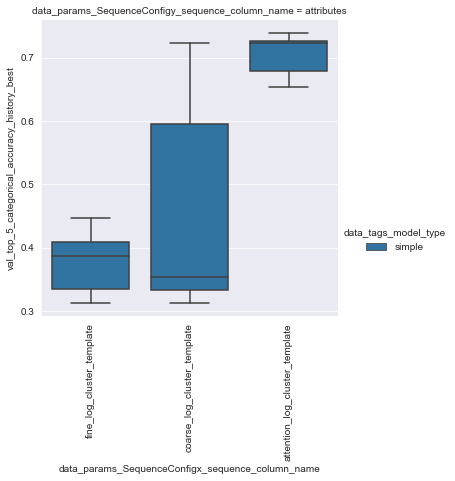

In [10]:
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))

sns.catplot(
    data=df[
        (df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x != "log_cluster_template"))
        & (df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes"))
        & (df["data_tags_model_type"].apply(lambda x: x == "simple"))
    ],
    hue="data_tags_model_type", 
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template"],
    kind="box",
    sharey="row",
).set_xticklabels(rotation=90)

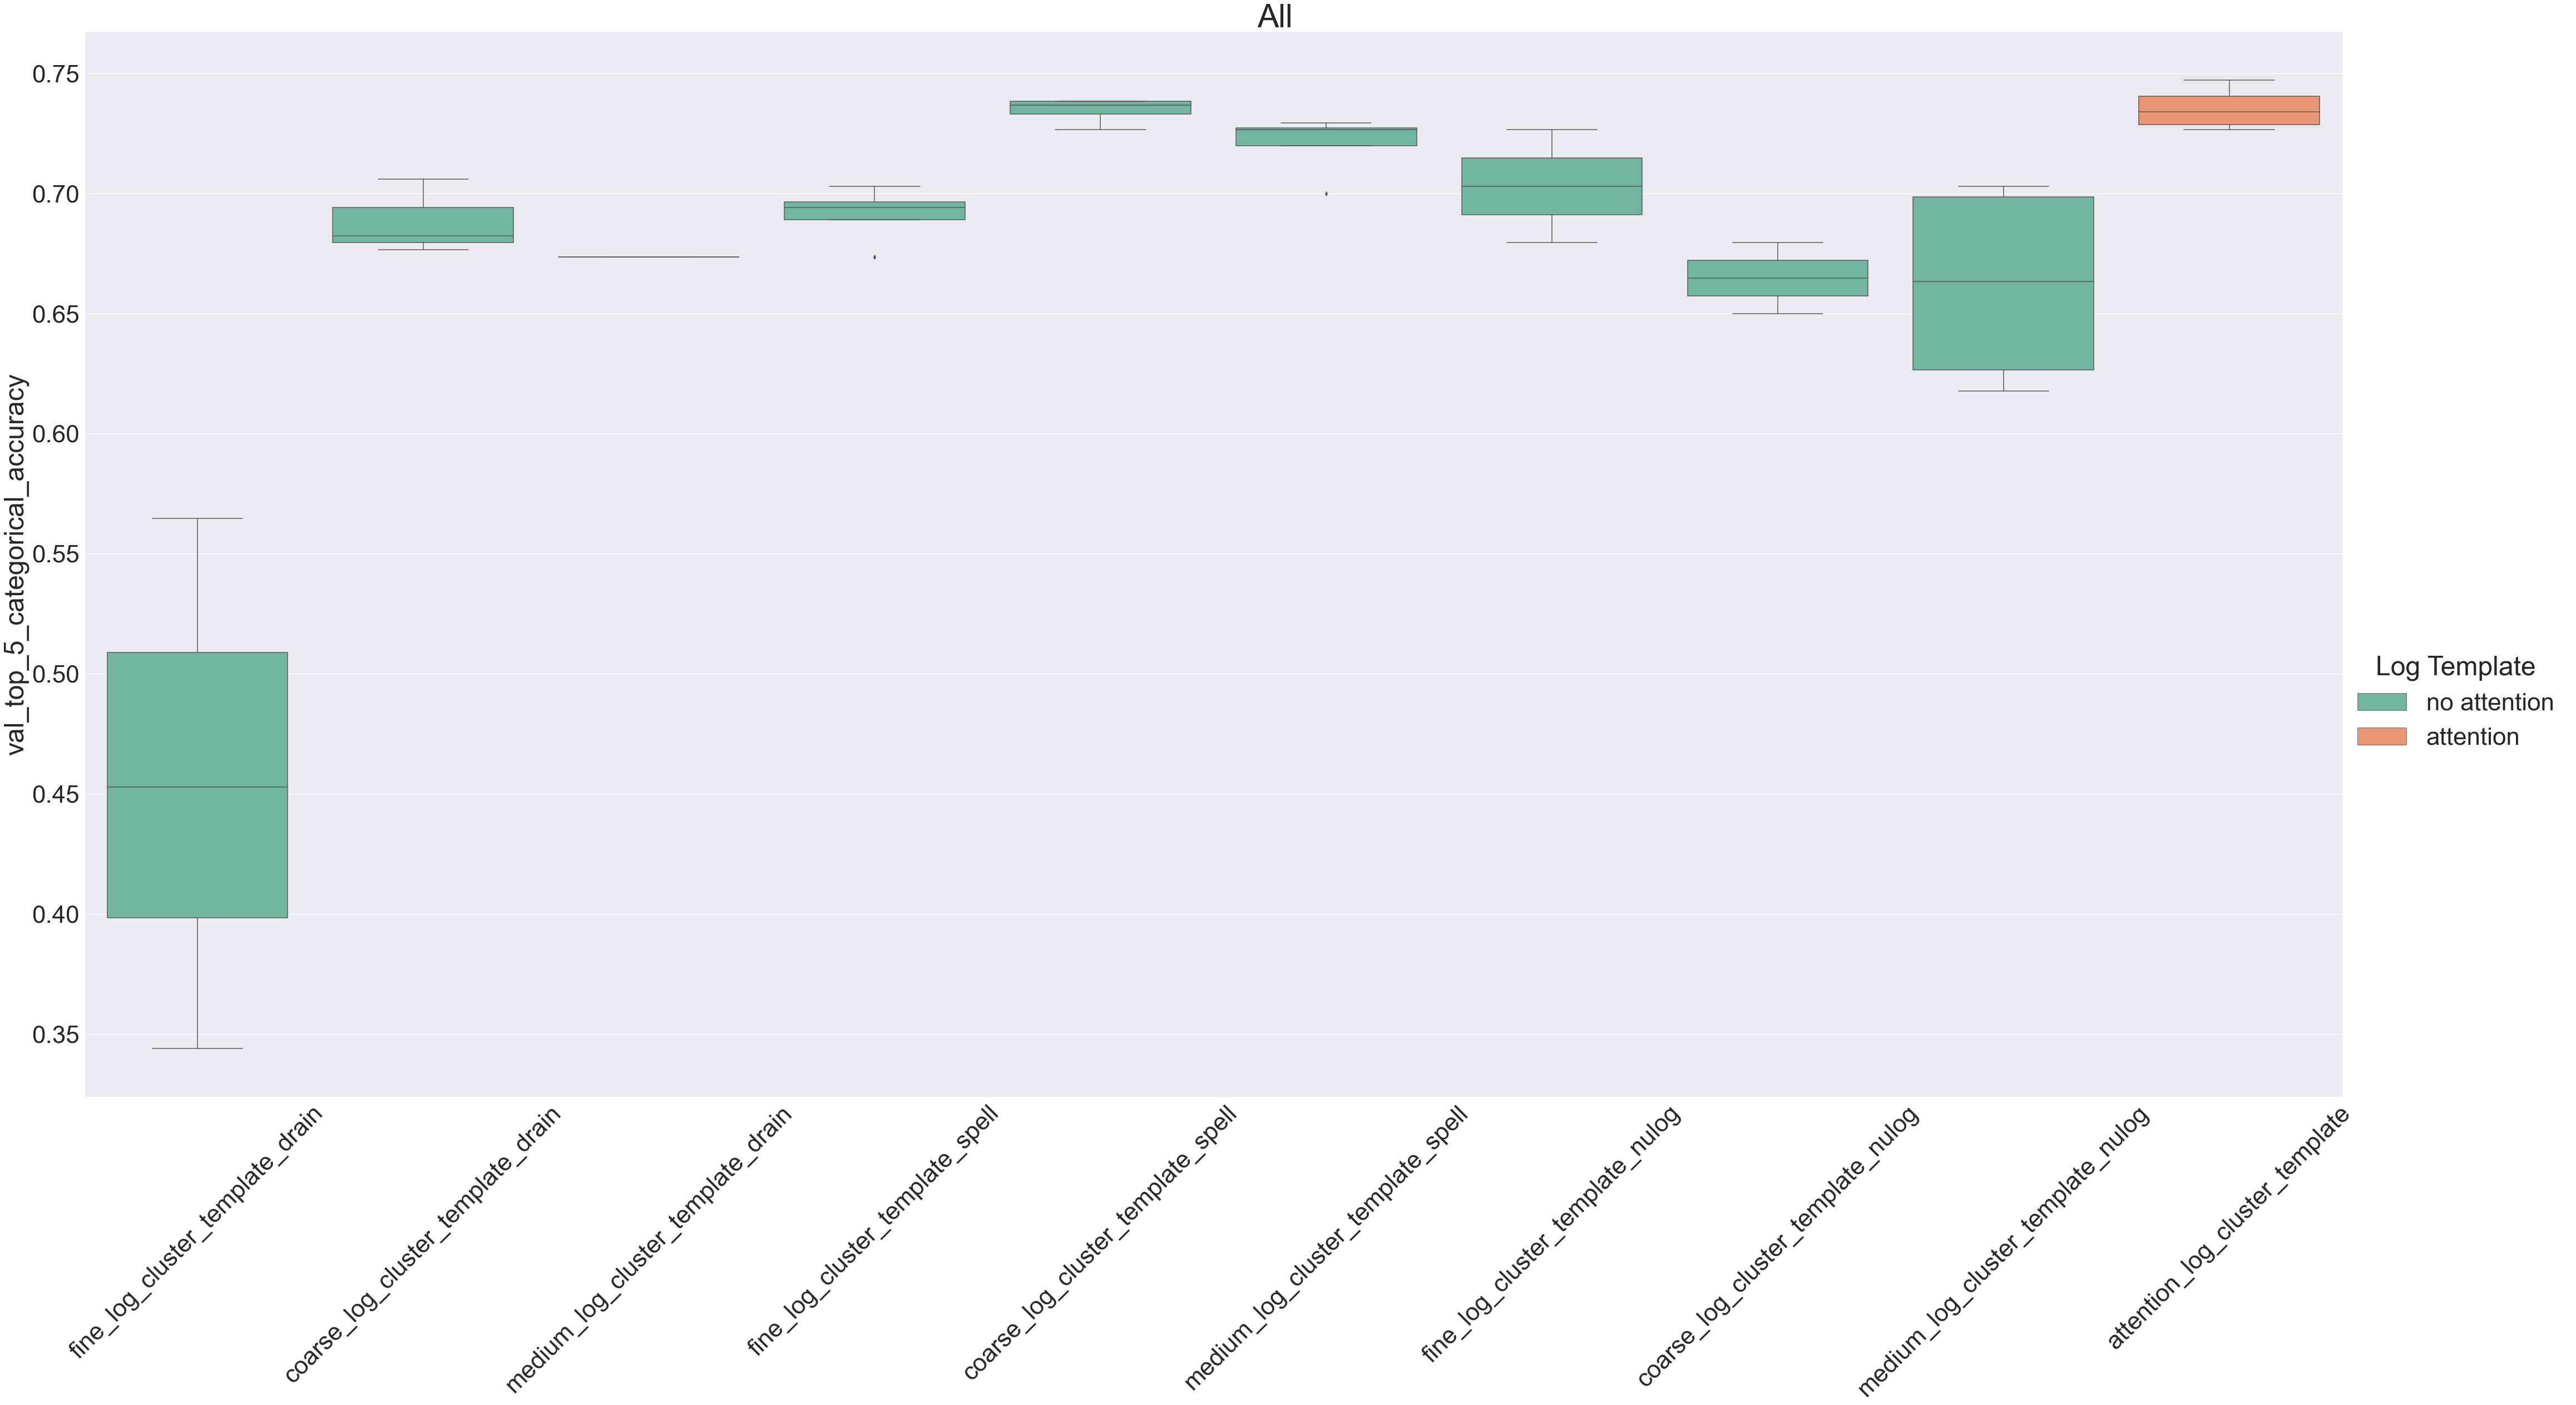

In [21]:
sns.set(font_scale=4)
df = huawei_metrics_df.copy()
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "": "attention_log_cluster_template"
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "no attention")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
        & df["data_params_HuaweiPreprocessorConfigremove_dates_from_payload"].apply(lambda x: x == "True")
        & df["data_params_ExperimentConfign_epochs"].apply(lambda x: x == "25")
        #& df["data_params_HuaweiPreprocessorConfiglog_parser"].apply(lambda x: x == "nulog")
    ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template_drain", "coarse_log_cluster_template_drain", "medium_log_cluster_template_drain", "fine_log_cluster_template_spell", "coarse_log_cluster_template_spell",
           "medium_log_cluster_template_spell", "fine_log_cluster_template_nulog", "coarse_log_cluster_template_nulog", "medium_log_cluster_template_nulog", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
    height=30,
    aspect=2,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("drain_results.png", dpi=300, bbox_inches="tight")
plt.suptitle("All")
plt.show()

In [24]:
huw = pd.read_pickle("../data/sequences_df.pkl")
huw

,num_logs,num_events,all_events,attributes,fine_log_cluster_template,coarse_log_cluster_template
0,169230,169230,"[[http_status#200.0, , fine_log_cluster_templa...","[[http_status#200.0, , , Hostname#wally113, pr...",[[fine_log_cluster_template#25 nov 2019 15 * *...,[[coarse_log_cluster_template#25 nov 2019 * * ...
